# Lab 3

## Conrad Appel & Eric Hawkins

In [1]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import os 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import pandas as p
from skimage.feature import match_template
import _pickle as cPickle
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
from random import randint
import copy

numlabels = 2

###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./lab3/imgs/
###

In [3]:
dics = []
for root, directory, files in os.walk('imgs'):
    for f in files:
        if 'data_batch' in f:
            with open(root+'/'+f, 'rb') as fo:
                dics.append(cPickle.load(fo, encoding='latin1'))
total_imgs = []
for dic in dics:
    for i in range(len(dic['data'])):
        curpic = []
        curpic.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
        curpic.append(dic['labels'][i]) # int representing the label
        total_imgs.append(curpic)

total_imgs = np.array(total_imgs)
imgs_df = p.DataFrame(total_imgs)
imgs_df.columns = ['oneDColor', 'label']

In [4]:
def toGrayscale(img):
    oneDgray = np.zeros(1024)
    for j in range(1024):
        oneDgray[j] = 0.299*img[j] + 0.587*img[j+1024] + 0.114*img[j+2048]
    return oneDgray

imgs_df['oneDGray'] = imgs_df['oneDColor'].apply(toGrayscale)

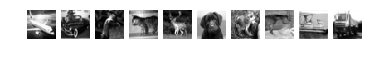

In [5]:
f, axes = plt.subplots(1,10)
for label in range(10):
    axes[label].axis('off')
    axes[label].imshow(imgs_df.loc[lambda df: df.label == label]['oneDGray'].sample(n=1).values[0].reshape((32,32)), cmap=plt.cm.gray)

## Linear Dimensionality Reduction via PCA

In [6]:
# Principal Components Analysis
pcas = []
for label in range(numlabels):
    x = imgs_df.loc[lambda df: df.label == label]
    
    pixels_are_cols = np.zeros(shape=(len(x), 1024))
    for i in range(len(x)):
        cur_pic = x['oneDGray'].values[i]
        for j in range(1024):
            pixels_are_cols[i][j] = cur_pic[j]
    
    x = pixels_are_cols
    y = [True]*len(x)
    n_comps = 175

    pca = PCA(n_components=n_comps)
    X_pca = pca.fit(x)
    pcas.append((x, pca, X_pca))

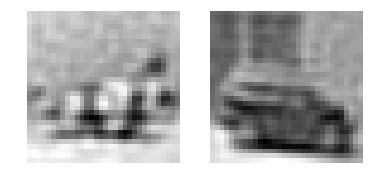

In [7]:
f, axes = plt.subplots(1, numlabels)
for label in range(numlabels):
    axis = axes[label] if numlabels > 1 else axes
    eigenpics = pcas[label][1].components_.reshape((n_comps, 32, 32))
    np.random.shuffle(pcas[label][0])
    recd = pca.inverse_transform(pca.transform(pcas[label][0][0].reshape(1, -1)))
    axis.axis('off')
    axis.imshow(recd.reshape((32,32)), cmap=plt.cm.gray)

## Non-Linear Dimensionality Reduction via Kernel PCA

In [8]:
# Kernel Principal Component Analysis
kpcas = []
for label in range(numlabels):
    x = imgs_df.loc[lambda df: df.label == label]
    
    pixels_are_cols = np.zeros(shape=(len(x), 1024))
    for i in range(len(x)):
        cur_pic = x['oneDGray'].values[i]
        for j in range(1024):
            pixels_are_cols[i][j] = cur_pic[j]
    
    x = pixels_are_cols
    y = [True]*len(x)
    n_comps = 175

    kpca = KernelPCA(n_components=n_comps, kernel='rbf', fit_inverse_transform=True, gamma=15)
    X_kpca = kpca.fit(x)
    kpcas.append((x, kpca, X_kpca))

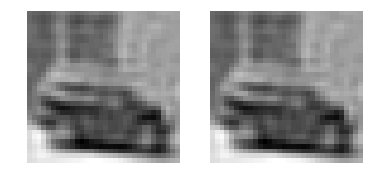

In [9]:
f, axes = plt.subplots(1, numlabels)
for label in range(numlabels):
    axis = axes[label] if numlabels > 1 else axes
    #np.random.shuffle(kpcas[label][0])
    axis.axis('off')
    axis.imshow(recd.reshape((32,32)), cmap=plt.cm.gray)

## DAISY

In [108]:
def apply_daisy(row):
    row = row[2]
    feat = daisy(row.reshape((32,32)),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

# calculate bag of features for each image
daisies = np.apply_along_axis(apply_daisy, 1, imgs_df)

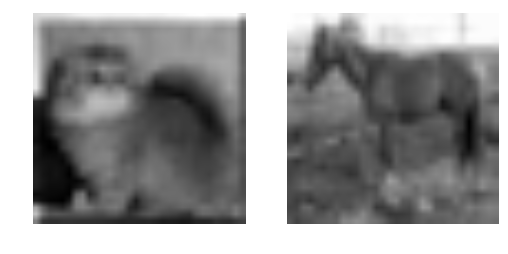

In [132]:
# pick a random image and calculate its distance from the other images according to the DAISY features
index1 = randint(0, len(daisies))
dist_matrix = pairwise_distances(daisies, daisies[index1].reshape((1, -1)))
dist_matrix[index1] = np.infty
index2 = np.argmin(dist_matrix)

# display random image and its closest match using the DAISY features
f, axes = plt.subplots(1,2)
axes[0].axis('off')
axes[1].axis('off')
tmp = axes[0].imshow(imgs_df['oneDGray'][index1].reshape((32,32)), cmap=plt.cm.gray)
tmp = axes[1].imshow(imgs_df['oneDGray'][index2].reshape((32,32)), cmap=plt.cm.gray)